# **Diabetic Patient Readmission: Modeling**

This dataset was analyzed by numerous Virginia Commonwealth University faculty in a recent research article which is accompanied by feature descriptions. These can be found at https://www.hindawi.com/journals/bmri/2014/781670/tab1/.

In [1]:
#conda install -c conda-forge imbalanced-learn      https://imbalanced-learn.org/stable/references/index.html#api

import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, plot_roc_curve, roc_curve

from timeit import default_timer as timer

np.random.seed(42)

In [2]:
df1 = pd.read_csv("clean_data2.csv")
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,missing,...,No,Up,No,No,No,No,No,Ch,Yes,Other
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,missing,...,No,Up,No,No,No,No,No,Ch,Yes,Other
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,missing,...,No,Steady,No,No,No,No,No,Ch,Yes,Other
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,missing,...,No,Steady,No,No,No,No,No,No,Yes,Other


In [3]:
print('Percent "other" in "readmitted":',100 * round(1-(df1['readmitted'].value_counts()[1] / 
                                                        df1['readmitted'].value_counts().sum()), 5))

Percent "other" in "readmitted": 91.579


# Pre-processing:

In [4]:
df1 = df1.drop(columns=['encounter_id','patient_nbr'])    #irrelevant for modeling

In [5]:
X = df1.drop(columns=['readmitted'])
y = df1[['readmitted']].values.ravel()
X.shape, y.shape

((64781, 42), (64781,))

In [6]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,6,25,1,1,41,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,1,7,3,59,0,18,0,0,9,...,0,1,1,0,0,0,0,0,0,1
2,1,1,7,2,44,1,16,0,0,7,...,0,1,1,0,0,0,0,0,0,1
3,1,1,7,1,51,0,8,0,0,5,...,1,0,1,0,0,0,0,0,0,1
4,2,1,2,3,31,6,16,0,0,9,...,1,0,1,0,0,0,0,0,1,1


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split:

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=42)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48585, 2298) (16196, 2298) (48585,) (16196,)


In [10]:
print('Percent "other" in "readmitted" of y_train:', 100*(round(1-(pd.DataFrame(y_train).value_counts()[1] / 
                                                        pd.DataFrame(y_train).value_counts().sum()), 5)))

Percent "other" in "readmitted" of y_train: 91.598


In [11]:
y_test_df = pd.DataFrame(y_train)
y_test_df.value_counts()

Other    44503
<30       4082
dtype: int64

In [13]:
scale_pos_weight = round(44503/4082,2)
print(scale_pos_weight)

10.9


The above will be useful to know for future model evalutaion and some tuning.

# Model Tuning and Evaluation:

**K-Nearest Neighbors:**

In [11]:
knn = KNeighborsClassifier()

param_dist = {'n_neighbors': np.arange(1,40),
              'leaf_size': np.arange(1,50),
              'p': [1,2]}

knn_cv = RandomizedSearchCV(knn, param_dist, cv=5, verbose=2, n_jobs=-1)

In [12]:
start = timer()

knn_cv = knn_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
8949 seconds elapsed.


In [13]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9159822990634969
Best Parameters: {'p': 1, 'n_neighbors': 28, 'leaf_size': 41}


In [11]:
params = {'p': 1, 'n_neighbors': 28, 'leaf_size': 41}
best_knn = KNeighborsClassifier(**params, n_jobs=-1) # ** unpacks dict values to function arguments

In [13]:
start = timer()

best_knn = best_knn.fit(X_train, y_train)

print('Training Accuracy:', best_knn.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

Training Accuracy: 0.9159822990634969
1514 seconds elapsed.


91.598 percent accurate is mediocre in light of the fact that an estimator which simply predicts 'other' every time would achieve the same score on the training data.

In [14]:
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_knn.classes_))

              precision    recall  f1-score   support

         <30       0.00      0.00      0.00      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.46      0.50      0.48     16196
weighted avg       0.84      0.92      0.87     16196



In [35]:
auc_score_tr = roc_auc_score(y_train, best_knn.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.721088731825609
Test AUC: 0.5706338926548618


Not the best AUC from the K-Nearest Neighbors model.

**Random Forest:**

In [14]:
max_depth = np.arange(10, 100, 10)
max_depth = np.append(max_depth, None)

rfclf = RandomForestClassifier(class_weight='balanced')

param_dist = {'max_depth': max_depth, 'n_estimators': np.arange(200, 2000, 200)}

rfclf_cv = RandomizedSearchCV(rfclf, param_dist, cv=5, verbose=2, n_jobs=-1)

In [15]:
start = timer()

rfclf_cv = rfclf_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
15801 seconds elapsed.


In [16]:
print("Best Score:" + str(rfclf_cv.best_score_))
print("Best Parameters: " + str(rfclf_cv.best_params_))

Best Score:0.9159822990634969
Best Parameters: {'n_estimators': 1800, 'max_depth': 90}


The best Random Forest Classifier to come out of RandomizedSearchCV seems to be overfitting

In [16]:
params = {'n_estimators': 1800, 'max_depth': 90, 'class_weight':'balanced'}
best_rf = RandomForestClassifier(**params, n_jobs=-1)

In [17]:
start = timer()

best_rf = best_rf.fit(X_train, y_train)

print('Training Accuracy:', best_rf.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

Training Accuracy: 1.0
517 seconds elapsed.


In [18]:
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_rf.classes_))

              precision    recall  f1-score   support

         <30       0.00      0.00      0.00      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.46      0.50      0.48     16196
weighted avg       0.84      0.92      0.87     16196



In [37]:
auc_score_tr = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 1.0
Test AUC: 0.6291421586077698


The roughly-tuned Random Forest classifier is very overfit to the training data, but is still managing a better AUC on the test data than the K-Nearest Neighbors model.

**XGBoost:**

In [14]:
xgbclf = xgb.XGBClassifier(scale_pos_weight=10.9, objective='binary:logistic')

param_dist = {'learning_rate': np.arange(0.0, 1.0, 0.1),
              'n_estimators': np.arange(100, 1000, 100),
              'max_depth': np.arange(3, 15, 2)}

xgbclf_cv = RandomizedSearchCV(xgbclf, param_dist, cv=5, verbose=2, n_jobs=-1)

Note: scale_pos_weight argument balances class weights and is = # of neg observations / # of pos observations

In [18]:
start = timer()

xgbclf_cv = xgbclf_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[01:50:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
19675 seconds elapsed.


In [19]:
print("Best Score:" + str(xgbclf_cv.best_score_))
print("Best Parameters: " + str(xgbclf_cv.best_params_))

Best Score:0.9154265719872388
Best Parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1}


In [20]:
params = {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1}
best_xgb = xgb.XGBClassifier(**params, scale_pos_weight=10.9, objective='binary:logistic', n_jobs=-1)

In [21]:
start = timer()

best_xgb = best_xgb.fit(X_train, y_train)

print('Training Accuracy:', best_xgb.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

[02:18:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.9202428733148091
215 seconds elapsed.


In [22]:
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_xgb.classes_))

              precision    recall  f1-score   support

         <30       0.48      0.01      0.02      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.70      0.50      0.49     16196
weighted avg       0.88      0.92      0.88     16196



Immediately the precision score on our target class is looking much better than with any other model. This, coupled with a non-zero f1-score, puts XGB at the top of the pack.

In [28]:
best_xgb.classes_

array(['<30', 'Other'], dtype=object)

In [38]:
auc_score_tr = roc_auc_score(y_train, best_xgb.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.8796493997404378
Test AUC: 0.6363207971077407


In [24]:
features = X.keys()
imp = list(best_xgb.feature_importances_)
imp_df = pd.DataFrame((zip(features, imp)), columns =['Features', 'Importance scores'])
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df.head(50))

                                               Features  Importance scores
1                              discharge_disposition_id           0.007156
1019                                         diag_2_413           0.005845
2009                                         diag_3_788           0.005281
926                                          diag_2_295           0.005210
190                                        diag_1_250.1           0.004671
594                                          diag_1_728           0.004494
996                                           diag_2_38           0.004178
464                                          diag_1_562           0.004147
917                                          diag_2_286           0.004091
1084                                         diag_2_491           0.004036
1733                                         diag_3_411           0.004026
67    medical_specialty_PhysicalMedicineandRehabilit...           0.003966
1813                     

It makes sense to see discharge_disposition_id at the top of this table, as it is indicative of the state of a patient upon discharge.

Diagnoses of 250.x indicate a diabetes-related diagnosis and so it makes sens to see many of these showing up here as well.

It is also sensible to see the affiliated medical specialties of Surgery-Cardiovascular/Thoracic and -General.

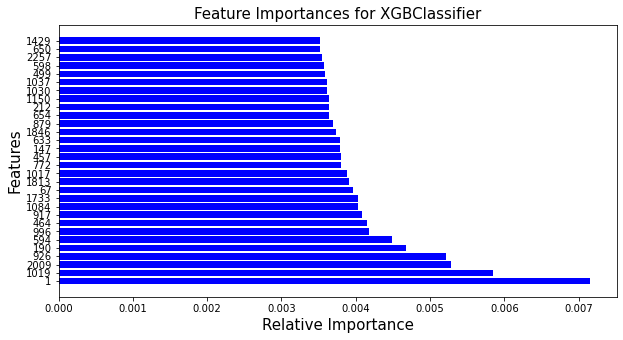

In [25]:
plt.figure(figsize=(10,5))
_=plt.barh(imp_df['Features'].head(30), imp_df['Importance scores'].head(30), align='center', color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for XGBClassifier',fontsize=15)
plt.yticks(imp_df['Features'].head(30), imp_df['Features'].head(30).index)
plt.show()

In [26]:
100*imp_df['Importance scores'].head(30).sum()

12.338317930698395

In [27]:
100*30/2298

1.3054830287206267

The above shows that the top 30 features explain 12.34% of the variance seen in the dataset, while making up only 1.31% of the total considered features. This shows a fair relationship to the top 30, but the model is definitely evaluating across *a lot* of features to attain a classification.

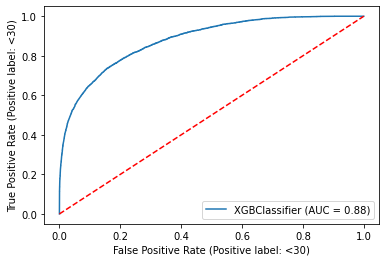

In [46]:
_=plot_roc_curve(best_xgb, X_train, y_train, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

A decent AUC

**Thresholding the xgb classifier:**

In [48]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_train, best_xgb.predict_proba(X_train)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.10979146
OptTPR: 0.760656540911318 OptFPR: 0.18171808642114015


In [53]:
roc_data = pd.DataFrame(zip(fpr,tpr,thresholds,gmean),columns=['fpr','tpr','threshold','gmean'])
roc_data = roc_data.sort_values('tpr', ascending=False).reset_index(drop=True)
roc_data

,fpr,tpr,threshold,gmean
0,1.000000,1.000000,0.004747,0.000000
1,0.919893,1.000000,0.032820,0.283032
2,0.920500,1.000000,0.032754,0.281958
3,0.920545,1.000000,0.032748,0.281878
4,0.921017,1.000000,0.032654,0.281040
...,...,...,...,...
6776,0.000045,0.051200,0.499700,0.226270
6777,0.000000,0.048996,0.506043,0.221349
6778,0.000022,0.048996,0.504771,0.221347
6779,0.000000,0.000245,0.873475,0.015652


In [54]:
np.argmax(roc_data.gmean)

3464

In [55]:
roc_data.iloc[3460:3470]

,fpr,tpr,threshold,gmean
3460,0.182707,0.761146,0.109641,0.788720
3461,0.182707,0.760902,0.109641,0.788593
3462,0.182055,0.760902,0.109726,0.788908
3463,0.182055,0.760657,0.109730,0.788781
3464,0.181718,0.760657,0.109791,0.788943
3465,0.181718,0.760412,0.109794,0.788816
3466,0.181561,0.760412,0.109825,0.788892
3467,0.181538,0.760167,0.109828,0.788776
3468,0.181561,0.760167,0.109827,0.788765
3469,0.181538,0.759922,0.109829,0.788649


In [59]:
best_xgb.classes_

array(['<30', 'Other'], dtype=object)

In [74]:
threshold = 0.109791

X_test_proba = pd.DataFrame(best_xgb.predict_proba(X_test), columns=['Pos_class_proba','class'])

print(X_test_proba.head())

for i in range(len(X_test_proba)):
    if X_test_proba['Pos_class_proba'].iloc[i] > threshold:
        X_test_proba['class'].iloc[i] = '<30'
    else:
        X_test_proba['class'].iloc[i] = 'Other'

print(X_test_proba.head())

y_pred_thresh = X_test_proba

   Pos_class_proba     class
0         0.102941  0.897059
1         0.066375  0.933625
2         0.016368  0.983632
3         0.036854  0.963146
4         0.096858  0.903142
   Pos_class_proba  class
0         0.102941  Other
1         0.066375  Other
2         0.016368  Other
3         0.036854  Other
4         0.096858  Other


In [80]:
y_pred_thresh['class'].value_counts()

Other    12264
<30       3932
Name: class, dtype: int64

In [87]:
print(classification_report(y_test, y_pred_thresh['class'], labels=best_xgb.classes_))

              precision    recall  f1-score   support

         <30       0.14      0.40      0.21      1373
       Other       0.93      0.77      0.85     14823

    accuracy                           0.74     16196
   macro avg       0.54      0.59      0.53     16196
weighted avg       0.87      0.74      0.79     16196



Our best-looking classification report yet. The highest f1-score on our target class by a huge margin.

In [89]:
y_test_df = pd.DataFrame(y_test)
y_test_df.value_counts()

Other    14823
<30       1373
dtype: int64

**XGB With Over-Sampling of the minority (Target) class:**

In [82]:
from imblearn.over_sampling import RandomOverSampler

start=timer()

ros = RandomOverSampler(sampling_strategy=1, random_state=None)     #set 1:1 ratio for pos_class:neg_class
Xtr_res, ytr_res = ros.fit_resample(X_train, y_train)

end=timer()
print(f'{round(end-start)} seconds elapsed.')

1 seconds elapsed.


In [83]:
X_train.shape, y_train.shape

((48585, 2298), (48585,))

In [84]:
Xtr_res.shape, ytr_res.shape

((89006, 2298), (89006,))

In [85]:
pd.DataFrame(ytr_res).value_counts()

<30      44503
Other    44503
dtype: int64

In [86]:
pd.DataFrame(ytr_res).value_counts()[1]/pd.DataFrame(ytr_res).value_counts().sum()

0.5

In [91]:
res_xgbclf = xgb.XGBClassifier(objective='binary:logistic')

param_dist = {'learning_rate': np.arange(0.0, 1.0, 0.1),
              'n_estimators': np.arange(100, 1000, 100),
              'max_depth': np.arange(3, 15, 2)}

res_xgbclf_cv = RandomizedSearchCV(res_xgbclf, param_dist, cv=5, verbose=2, n_jobs=-1)

In [ ]:
start = timer()

res_xgbclf_cv = res_xgbclf_cv.fit(Xtr_res, ytr_res)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

In [ ]:
print("Best Score:" + str(res_xgbclf_cv.best_score_))
print("Best Parameters: " + str(res_xgbclf_cv.best_params_))

In [92]:
params = {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.5}
best_xgb_res = xgb.XGBClassifier(**params, objective='binary:logistic', n_jobs=-1)

In [93]:
start = timer()

best_xgb_res = best_xgb_res.fit(Xtr_res, ytr_res)

print('Training Accuracy:', best_xgb_res.score(Xtr_res, ytr_res))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

[12:11:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 1.0
1393 seconds elapsed.


In [94]:
y_pred_res = best_xgb_res.predict(X_test)
print(classification_report(y_test, y_pred_res, labels=best_xgb_res.classes_))

              precision    recall  f1-score   support

         <30       0.18      0.06      0.09      1373
       Other       0.92      0.97      0.95     14823

    accuracy                           0.90     16196
   macro avg       0.55      0.52      0.52     16196
weighted avg       0.86      0.90      0.87     16196



A good improvement for simply oversampling to a 1:1 ratio on a roughly-tuned XGBClassifier model.

In [95]:
features = X.keys()
imp = list(best_xgb_res.feature_importances_)
imp_df = pd.DataFrame((zip(features, imp)), columns=['Features', 'Importance scores'])
print(imp_df)
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df.head(30))

                            Features  Importance scores
0                  admission_type_id           0.000516
1           discharge_disposition_id           0.001118
2                admission_source_id           0.000525
3                   time_in_hospital           0.000474
4                 num_lab_procedures           0.000497
...                              ...                ...
2293      glipizide-metformin_Steady           0.000000
2294  metformin-rosiglitazone_Steady           0.000000
2295   metformin-pioglitazone_Steady           0.000000
2296                       change_No           0.000444
2297                 diabetesMed_Yes           0.000602

[2298 rows x 2 columns]
                                        Features  Importance scores
1154                                  diag_2_583           0.008278
1450                                 diag_2_E936           0.006679
1563                                  diag_3_236           0.005233
314                            

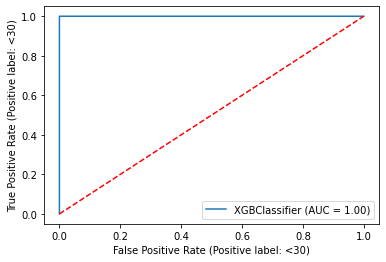

In [96]:
_=plot_roc_curve(best_xgb_res, Xtr_res, ytr_res, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

The model is overfitting, and will likely not generalize well.

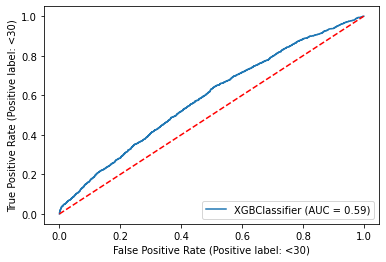

In [97]:
_=plot_roc_curve(best_xgb_res, X_test, y_test, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

0.59 is a poor AUC, but with more tuning, the oversampling method would probably prove beneficial.

In [98]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_test, best_xgb_res.predict_proba(X_test)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.90365255
OptTPR: 1.0 OptFPR: 0.0


In [99]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_test, best_xgb_res.predict_proba(X_test)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.0069440007
OptTPR: 0.6307356154406409 OptFPR: 0.4978749241044323


The best model would most likely be an XGBClassifier with the use of thresholding and oversampling on the minority class.